In [64]:
# Imports for alpaca and .env 
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame
import os
from pathlib import Path
import seaborn as sns
import pymc3 as pm
load_dotenv()

True

In [66]:
# Set Alpca API key and secret key, then insantiate an API object
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECURITY_KEY")

tradeapi = REST(alpaca_api_key, alpaca_secret_key, api_version='v2')


In [67]:
from datetime import date
import re
# Define functions I use to get Alpaca Trade API data
def calc_start_date(years_ago):
    """Calculates the date 'x' years ago"""
    to_day=str(date.today())
    match = re.match(r'(\d\d\d\d)-(\d\d)-(\d\d)', to_day)
    _yrsago= int(match.group(1))-years_ago
    _yrsago = str(_yrsago)+'-'+match.group(2)+'-'+match.group(3)
    return _yrsago

def get_company(ticker, start, end, tradeapi):
    """Executes the get_bars method from Alpaca Trade API"""
    return tradeapi.get_bars(
        ticker,
        TimeFrame.Day,
        start,
        end
    ).df

# Get Data from API:
spy_df = get_company("SPY", calc_start_date(20), "2022-03-30", tradeapi)
spy_df.reset_index(inplace=True)
# spy_df.to_csv("../Data/rawdata/SPY_data.csv")


<AxesSubplot:>

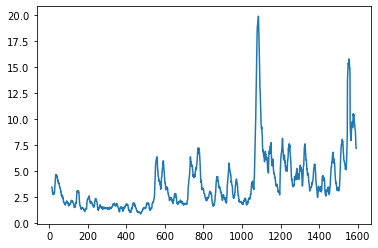

In [68]:
import pandas as pd
import numpy as np
# make a df with the values needed for the ATR calculation:
range_df = { 
               "date": spy_df['timestamp'] , 
               "hi-lo": abs( spy_df['high']-spy_df['low'] ), 
                "hi-cl": abs( spy_df['high'] - spy_df['close'].shift() ),
                "lo-cl": abs( spy_df['low'] - spy_df['close'].shift() )
}
# make a df out of our rage_df dictionary
range_df = pd.DataFrame(range_df)
# NaN exist because it subtracts the prior day's close, which doesn't exist in row one. Not important.
range_df.dropna(inplace=True)
range_df.set_index('date', inplace= True)

# Make a df of the maximum of ranges
true_range = pd.DataFrame( np.max(range_df, axis = 1) )
true_range.rename(columns= {0:'TR'}, inplace=True)
true_range.reset_index(inplace=True)

#plot a 14 day moving average of True Range (ATR)
true_range['TR'].rolling(14).mean().plot()




In [69]:

true_range.head()
true_range.to_csv("Data/rawdata/TR_data.csv")

In [70]:
vix_df = pd.read_csv('Data/cleandata/VIX_data.csv', index_col= 'timestamp')
spy_df = pd.read_csv('Data/cleandata/SPY_data.csv', index_col= 'timestamp')
my_price = spy_df.tail(1)['close'][0]
my_vol = vix_df.tail(1)['close'][0]


In [71]:
import Data.DataWrangle as dw
spy_df.drop(labels='id',axis=1, inplace= True)
combined_df = dw.combine_DFs([spy_df,vix_df],['SPY','VIX'])
combined_df.sort_index(inplace=True)
combined_df.dropna(inplace=True)




In [72]:
from libs.MCForecastTools import MCSimulation as MCsim

my_sim = MCsim(
    portfolio_data = combined_df,
    weights = [1,0],
    num_simulation = 100,
    num_trading_days = 252*2
)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


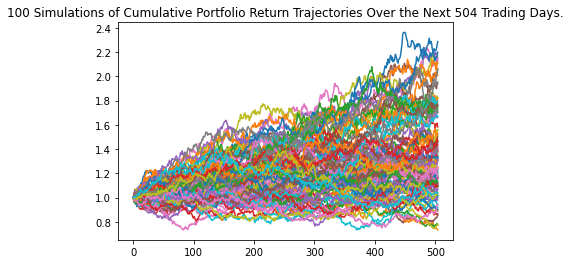

In [73]:
my_sim.plot_simulation()
my_returns = my_sim.simulated_return

In [74]:
spy_sim_df = (my_returns*my_price)
spy_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,...,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000,458.700000
1,443.932289,459.867735,460.662961,462.181902,460.680896,471.795646,453.454901,455.929348,454.476698,455.217959,...,456.516274,455.330547,456.457337,465.759144,462.243931,461.643189,454.625666,467.650261,456.507561,461.764878
2,440.118846,463.419304,469.575663,464.286740,458.617920,482.818415,460.626464,458.699636,456.178183,447.981622,...,457.144854,456.604835,449.449592,476.076009,459.473157,466.413471,448.818706,468.660356,455.186794,462.500337
3,444.147765,457.361546,461.018501,463.193836,457.153794,489.484792,453.980367,449.104291,460.670074,458.403098,...,451.077779,451.574994,448.716924,468.513706,459.019110,465.368413,446.108384,473.844224,459.540273,459.137784
4,439.001102,453.774553,457.716526,479.351399,458.495215,478.700453,452.263908,449.981685,468.214148,452.873169,...,450.168343,459.254458,437.998747,470.406738,449.945994,458.890472,444.724310,470.049898,459.621118,463.122958


In [75]:
my_sim = MCsim(
    portfolio_data = combined_df,
    weights = [0,1],
    num_simulation = 100,
    num_trading_days = 252*2
)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


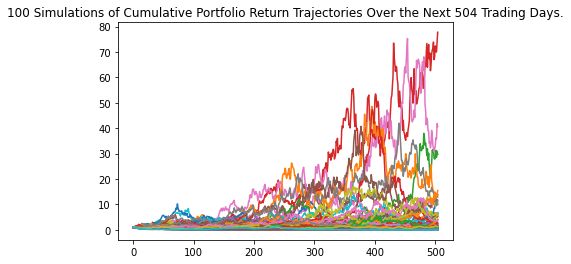

In [76]:
my_sim.plot_simulation()
my_returns = my_sim.simulated_return

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

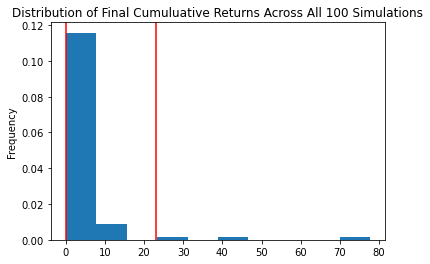

In [77]:
vix_sim_df = (my_returns*my_vol)
vix_sim_df.head()
my_sim.plot_distribution()

In [78]:
# pseudocode for Historical Backtesting
# When Vix > threshold 
# CHOOSE SPY PRICE at timestamp == vix.timestamp
# Lookup (timestamp + number of weeks)
# find SPY PRICE at  timestamp+''
# (currentSPY - CHOSEN SPY) = change in price
# "Historically, when the VIX crosses 'x', the SPY has inc/dec 'y' amount


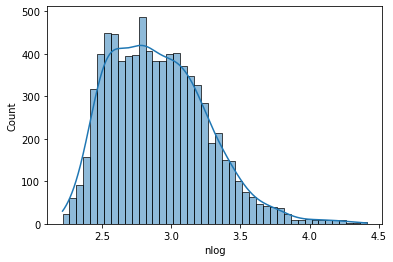

In [79]:
import seaborn as sns
import numpy as np
# A distribution can be called lognormal if the log of its distribution 
# is normally distributed
vix_df['nlog']=np.log(vix_df['close'])

fig =sns.histplot( vix_df['nlog'],
                   kde= True,
                   kde_kws= {'cut': 0,
                   'gridsize':4000,
                   'bw_adjust': 1.5
                   }
                   
)



In [80]:

vix_df.reset_index(inplace=True)
spy_df.reset_index(inplace=True)



In [81]:
vix_df['vix_delta'] = (vix_df['close']-vix_df['close'].shift())/vix_df['close']
spy_df['spy_delta'] = (spy_df['close']-spy_df['close'].shift())/spy_df['close']

corr_df = pd.concat([vix_df, spy_df], axis= 1, join='inner')
corr_df[['vix_delta','spy_delta']].corr()

,vix_delta,spy_delta
vix_delta,1.000000,-0.000688
spy_delta,-0.000688,1.000000


<AxesSubplot:xlabel='vix_delta', ylabel='spy_delta'>

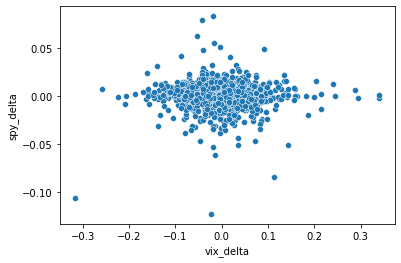

In [82]:
sns.scatterplot(
            data=corr_df,
            x= corr_df['vix_delta'],
            y= corr_df['spy_delta']
)

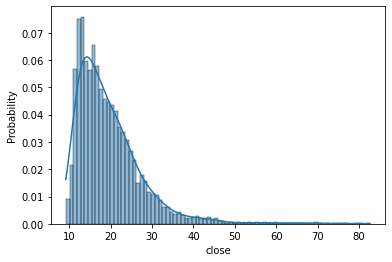

In [83]:
fig =sns.histplot( vix_df['close'],
                   kde= True,
                   stat= 'probability',
                   discrete= False,
                   kde_kws= {'cut': 0,
                   'gridsize':4000,
                   'bw_adjust': 1.5,
                   
                   }
                   
)

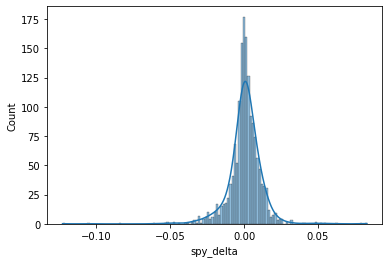

In [84]:
fig =sns.histplot( spy_df['spy_delta'],
                   kde= True,
                   kde_kws= {'cut': 0,
                   'gridsize':4000,
                   'bw_adjust': 1.5
                   }
                   
)

In [102]:
mu = vix_df['close'].mean()
sigma = vix_df['close'].std()
with pm.Model() as vix_model:
    x= pm.Normal('x', mu, sigma)
    likelihood = pm.Normal('likelihood', mu, sigma, observed=vix_df['close'])
    samples = pm.sample(1000, tune=1000, cores=2, random_seed=42)

C:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


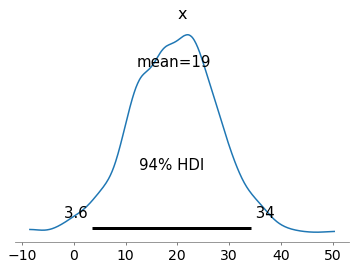

In [103]:
from arviz import plot_posterior
my_plot = plot_posterior(samples)

In [ ]:
with vix_model:
    likelihood = pm.Lognormal('likelihood', mu, sigma, observed=vix_df['close'])

In [97]:
with vix_model:
    samples = pm.sample(1000, tune=1000, cores=2, random_seed=42)

C:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:title={'center':'x'}>

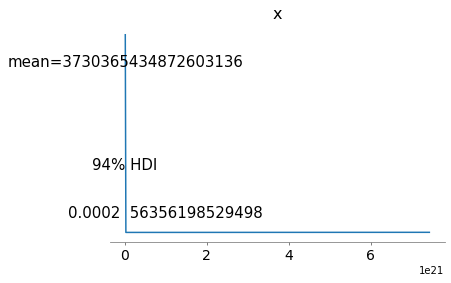